# Stock market prediction (LSTM)
We are using a  Long Short-Term Memory (LSTM) recurrent neural network to predict stock market prices. Stock market prices are time series data.

In [0]:
# We use the latest version of TensorFlow '2.0.0-beta1'
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

import os
import numpy as np

import pandas as pd
from pandas_datareader import data, wb

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import datetime as dt

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [0]:
#Load stock price data for index S&P500
DAY30 = dt.timedelta(days=30)
ticker = '^GSPC'
startdate = '01/01/2000'
enddate = dt.datetime.today().strftime("%m/%d/%Y")
    
stock_price_data = data.DataReader(ticker,data_source='yahoo',start = str((dt.datetime.strptime(startdate, '%d/%m/%Y') - DAY30).date()), end=enddate)
stock_price_dataframe = pd.DataFrame(stock_price_data)

In [9]:
stock_price_dataframe.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-12-02,1409.040039,1397.719971,1397.719971,1409.040039,900700000,1409.040039
1999-12-03,1447.420044,1409.040039,1409.040039,1433.300049,1006400000,1433.300049
1999-12-06,1434.150024,1418.250000,1433.300049,1423.329956,916800000,1423.329956
1999-12-07,1426.810059,1409.170044,1423.329956,1409.170044,1085800000,1409.170044
1999-12-08,1415.660034,1403.880005,1409.170044,1403.880005,957000000,1403.880005


In [10]:
stock_price_dataframe.shape

(4948, 6)

Text(0, 0.5, 'S&P500')

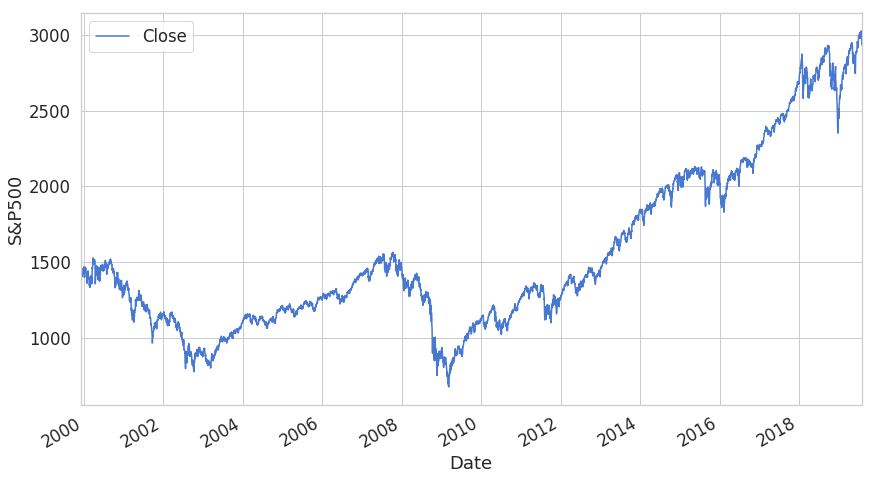

In [12]:
ax = stock_price_dataframe.plot(y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("S&P500")

In [0]:
#Normalization to range [0,1]
#The scaler expects the data to be shaped as (x, y), so we add a dummy dimension using reshape before applying it.
scaler = MinMaxScaler()
close_price = stock_price_dataframe.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [14]:

scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)
np.isnan(scaled_close).any()

False

In [0]:

SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

#5% for testing
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [16]:
X_train.shape

(4605, 99, 1)

In [17]:
X_test.shape

(243, 99, 1)

In [0]:

#Linear activation function (proportional to the input).
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()
model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [0]:
#Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
#Train the model
#No shuffling as it is time series data! 
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Train on 4144 samples, validate on 461 samples
Epoch 1/50
4144/4144 [==============================] - 9s 2ms/sample - loss: 0.0049 - val_loss: 0.0068
Epoch 2/50
4144/4144 [==============================] - 3s 781us/sample - loss: 0.0049 - val_loss: 0.0046
Epoch 3/50
4144/4144 [==============================] - 3s 788us/sample - loss: 0.0057 - val_loss: 0.0077
Epoch 4/50
4144/4144 [==============================] - 3s 787us/sample - loss: 0.0076 - val_loss: 0.0546
Epoch 5/50
4144/4144 [==============================] - 3s 791us/sample - loss: 0.0129 - val_loss: 0.0524
Epoch 6/50
4144/4144 [==============================] - 3s 789us/sample - loss: 0.0157 - val_loss: 0.0819
Epoch 7/50
4144/4144 [==============================] - 3s 787us/sample - loss: 0.0139 - val_loss: 0.0427
Epoch 8/50
4144/4144 [==============================] - 3s 790us/sample - loss: 0.0156 - val_loss: 0.0044
Epoch 9/50
4144/4144 [==============================] - 3s 789us/sample - loss: 0.0206 - val_loss: 0.0102
E

In [21]:
#Evaluate the model
model.evaluate(X_test, y_test)

243/243 [==============================] - 1s 3ms/sample - loss: 0.0055


0.005546003775556146

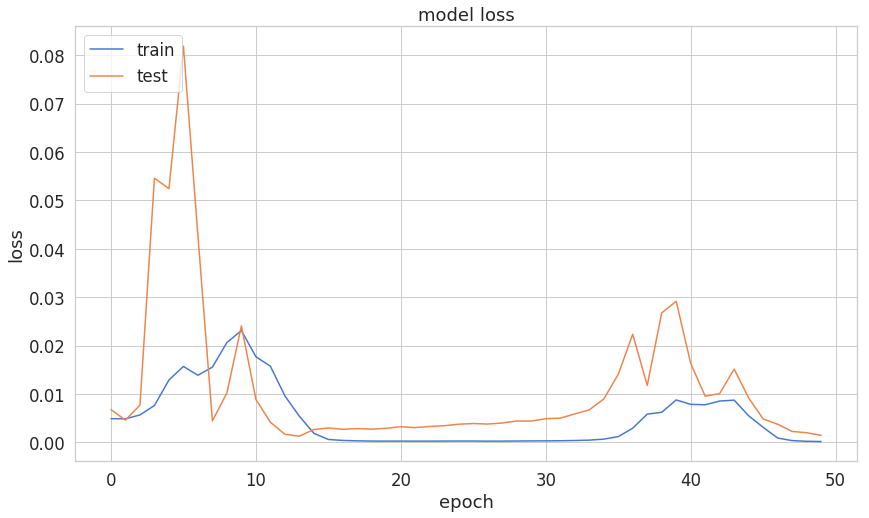

In [22]:
#Plot the loss function for training and test per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

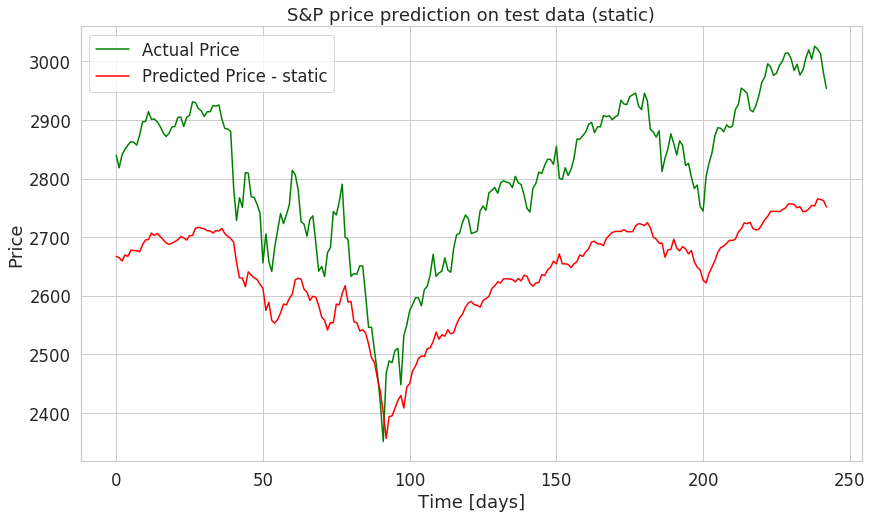

In [24]:
#Predict on the test data ("static prediction")
y_hat = model.predict(X_test)

#Scale back to prices (no longer scaled in the [0, 1] range)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
#Plot the graphs
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price - static", color='red')
 
plt.title('S&P price prediction on test data (static)')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [0]:
#Predict on the test data time frame ("dynamic prediction")
def moving_test_window_preds(n_future_preds):
    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []  # Use this to store the prediction made on each test window
    moving_test_window = [X_test[0, :].tolist()]  # Creating the first test window
    moving_test_window = np.array(moving_test_window)  # Making it an numpy array

    for i in range(n_future_preds):
        preds_one_step = model.predict(
            moving_test_window)  # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0, 0])  # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1, 1,
                                                1)  # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:, 1:, :], preds_one_step),
                                            axis=1)  # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end

    preds_moving = np.array(preds_moving)
    preds_moving = scaler.inverse_transform(preds_moving.reshape(-1,1))

    return preds_moving

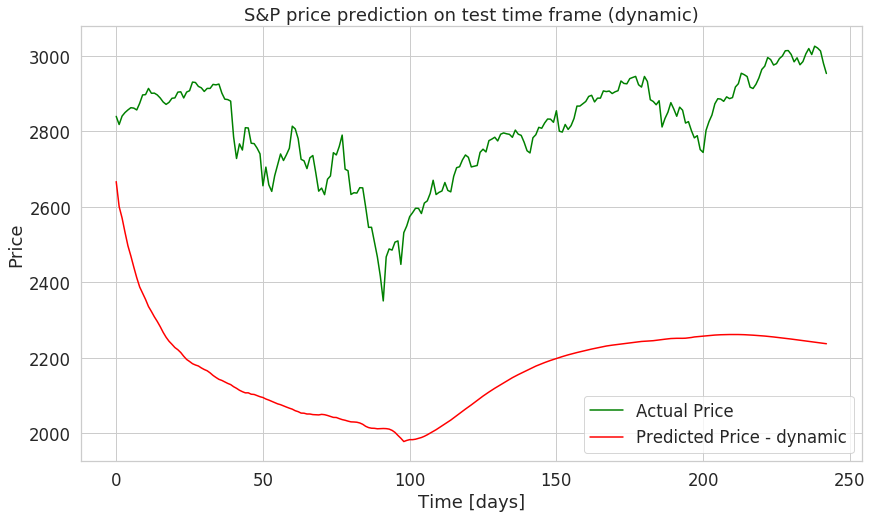

In [26]:
preds_moving = moving_test_window_preds(243)

#Plot the graphs
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(preds_moving, label="Predicted Price - dynamic", color='red')
 
plt.title('S&P price prediction on test time frame (dynamic)')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();